<a href="https://colab.research.google.com/github/sofiapapadron/The-DESC-ELAsTiCC-Challenge/blob/main/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The DESC ELAsTiCC Challenge**

# **0. Entendiemiento del negocio**

About ELAsTiCC

The purpose of ELAsTiCC ("Extended LSST Astronomical Time-series Classification Challenge") is to spur the creation and testing of an end-to-end real-time pipeline for time-domain science. The challenge starts with a simulation of ~5 million detected events that includes ~50 million alerts. These alerts will be streamed from LSST to brokers, who will classify the events and send new alerts with classifications back to DESC. A talk about ELAsTiCC given at the LSSTC Enabling Science Broker Workshop in 2021 can be found on YouTube. Two posters on ELAsTiCC given at conferences can be found below on this page.

For discussion or questions about the challenge, use the #elasticc-comms channel on the DESC Slack.

The first ELAsTiCC campaign ran from September 2022 until early January 2023. Metrics and diagnostics from that campaign can be found on the ELAsTiCC page of the DESC TOM (login required).

The Second ELAsTiCC campaign (dubbed ELAsTiCC2) ran from mid-November to mid-December 2023, streaing alerts at ~3× the rate of the first campaign. Diagnostics and some metrics from that campaign can be found on the ELAsTiCC2 page of the DESC TOM (login required).

There is a new github repository for ELAsTiCC-related code and information: LSSTDESC/elasticc.



#**1. Importar librerias**


In [ ]:
from astropy.table import Table
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# **2. Carga de datos**

In [ ]:
# URLs de los datos
url_head = "https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/ELASTICC2_TRAINING_SAMPLE_2/ELASTICC2_TRAIN_02_CLAGN/ELASTICC2_TRAIN_02_NONIaMODEL0-0001_HEAD.FITS.gz"
url_phot = "https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/ELASTICC2_TRAINING_SAMPLE_2/ELASTICC2_TRAIN_02_CLAGN/ELASTICC2_TRAIN_02_NONIaMODEL0-0001_PHOT.FITS.gz"

# Cargar datos
info = Table.read(url_head).to_pandas()
phot = Table.read(url_phot).to_pandas()

**info** proporciona una visión general de cada objeto y sus metadatos.

**phot** contiene las observaciones detalladas (fotometría) de cada objeto en diferentes momentos y bandas.


##**2.1 Manejo inicial de datos**

In [ ]:
# Convertir tipos de columnas a string
info_columns_that_should_be_strings = {"SNID", "IAUC"}
phot_columns_that_should_be_strings = {"BAND", "FIELD"}
info_convert_obj_to_str = {c: "string" for c in info_columns_that_should_be_strings}
phot_convert_obj_to_str = {c: "string" for c in phot_columns_that_should_be_strings}
info = info.astype(dtype=info_convert_obj_to_str)
phot = phot.astype(dtype=phot_convert_obj_to_str)

In [ ]:
# Usar el primer objeto como ejemplo
i = 0
this_df = phot[info["PTROBS_MIN"][i]-1 : info["PTROBS_MAX"][i]-1]
bands = set(this_df["BAND"])

In [ ]:
# Elegir colores para los datos de cada filtro
colors = {
    "u": "blue",
    "g": "green",
    "r": "orange",
    "i": "red",
    "z": "purple",
    "Y": "yellow",
}
for k, v in frozenset(colors.items()):
    colors[k + " "] = v

##2.2 Exploración de datos

### Total de datos

In [ ]:
# Total de datos en info
total_filas_info, total_columnas_info = info.shape
print(f"Total de filas en info: {total_filas_info}")
print(f"Total de columnas en info: {total_columnas_info}")

# Total de datos en phot
total_filas_phot, total_columnas_phot = phot.shape
print(f"Total de filas en phot: {total_filas_phot}")
print(f"Total de columnas en phot: {total_columnas_phot}")

Total de filas en info: 2711
Total de columnas en info: 180
Total de filas en phot: 709595
Total de columnas en phot: 21


### Resumen estadístico

In [ ]:
# Resumen estadístico del DataFrame info
info_summary = info.describe(include='all')
print(info_summary)

                    SNID              IAUC    FAKE           RA          DEC  \
count               2711              2711  2711.0  2711.000000  2711.000000   
unique              2711                 1     NaN          NaN          NaN   
top     51107972          NULL                 NaN          NaN          NaN   
freq                   1              2711     NaN          NaN          NaN   
mean                 NaN               NaN     2.0   171.892407   -23.795915   
std                  NaN               NaN     0.0   107.385910    21.752880   
min                  NaN               NaN     2.0     0.052675   -76.341810   
25%                  NaN               NaN     2.0    72.799051   -39.206025   
50%                  NaN               NaN     2.0   169.060345   -21.801553   
75%                  NaN               NaN     2.0   270.122768    -6.735840   
max                  NaN               NaN     2.0   359.990460    15.052419   

        PIXSIZE   NXPIX   NYPIX       S

Columnas categóricas:

SNID y IAUC son columnas que parecen ser identificadores únicos (SNID tiene 2711 valores únicos) y no proporcionan un resumen estadístico significativo, como media o desviación estándar.

FAKE: Todos los valores son 2, lo que indica que esta columna no tiene variación.


Coordenadas Celestes:

RA (Ascensión Recta) y DEC (Declinación) son las coordenadas celestes en el cielo.
RA varía de 0.05 a 359.99 grados, con una media de 171.89 grados.
DEC varía de -76.34 a 15.05 grados, con una media de -23.79 grados.

Tamaño de Pixel y Número de Pixeles:

PIXSIZE: Fijo en 0.2, lo que significa que el tamaño del píxel es constante.

NXPIX y NYPIX: Fijos en -9, lo que puede indicar un valor por defecto o datos faltantes.

Tipos de Supernovas y Número de Observaciones:

SNTYPE: Parece indicar tipos de supernovas, con valores entre 60 y 160.

NOBS: Número de observaciones, con una media de 260 observaciones por objeto.

Columnas SIM_: Estas columnas parecen referirse a parámetros simulados como exposición (SIM_EXPOSURE) y fracción galáctica (SIM_GALFRAC), que están fijos en valores específicos como -9 o 1, indicando posiblemente datos simulados o por defecto.

In [ ]:
# Resumen estadístico del DataFrame phot
phot_summary = phot.describe(include='all')
print(phot_summary)

                  MJD    BAND    CCDNUM         FIELD       PHOTFLAG  \
count   709595.000000  709595  709595.0        709595  709595.000000   
unique            NaN       7       NaN             2            NaN   
top               NaN      i        NaN  VOID                    NaN   
freq              NaN  160917       NaN        706884            NaN   
mean     60597.386472     NaN      -9.0           NaN    1150.502988   
std       3814.855091     NaN       0.0           NaN    1853.740352   
min       -777.000000     NaN      -9.0           NaN       0.000000   
25%      60540.421050     NaN      -9.0           NaN       0.000000   
50%      60868.101700     NaN      -9.0           NaN       0.000000   
75%      61108.296600     NaN      -9.0           NaN    4096.000000   
max      61379.188400     NaN      -9.0           NaN    6144.000000   

             PHOTPROB        FLUXCAL    FLUXCALERR      PSF_SIG1  PSF_SIG2  \
count   709595.000000  709595.000000  7.095950e+05  70959

Fecha de Observación:
MJD: Tiempo medido en días julianos modificados. Varía de -777 a 61379, con una media de 60597 días.

Bandas de Observación:
BAND: Hay 7 bandas de observación, con i siendo la más frecuente.

Número de CCDs:
CCDNUM: Fijo en -9, lo que sugiere que esta columna no contiene datos útiles.

Campo de Observación:
FIELD: Hay dos campos de observación, con VOID siendo el más común.

Flujo y Error en el Flujo:
FLUXCAL: Varía ampliamente, de -13179.78 a 293394.09, con una media de 41.70. Esto indica que los valores de flujo tienen una gran dispersión.
FLUXCALERR: El error en el flujo también varía considerablemente, lo que puede afectar la precisión de las mediciones.

Parámetros del PSF:
PSF_SIG1: Parámetro relacionado con la función de dispersión de punto (PSF), varía de -9 a 9.39.
PSF_SIG2: Fijo en 0.

Otros Parámetros:

SKY_SIG: Indica la dispersión en el cielo, con una media de 38.52.

ZEROPT: Punto cero de la calibración, con una media de 30.79.

GAIN: Ganancia, con una media de 0.96.

Magnitudes Simuladas:
SIM_MAGOBS: Magnitudes observadas simuladas, varían de 13.68 a 99.00, con una media de 22.54.

### Análisis extras

#### Análisis de Distribución Espacial (RA y DEC)

Objetivo: Visualizar la distribución de los objetos en el cielo para identificar patrones o concentraciones (RA y DEC).

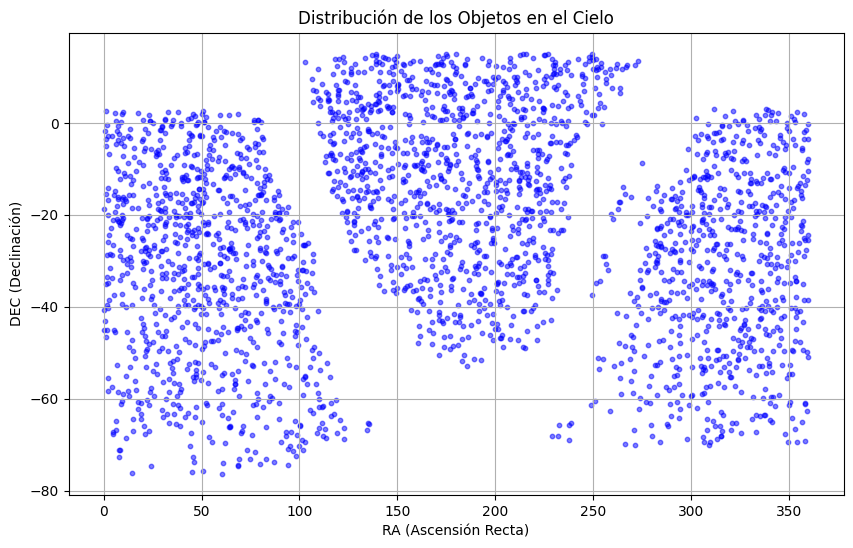

In [ ]:
# Scatter plot de la distribución de los objetos en el cielo
plt.figure(figsize=(10, 6))
plt.scatter(info['RA'], info['DEC'], alpha=0.5, s=10, c='blue')
plt.title('Distribución de los Objetos en el Cielo')
plt.xlabel('RA (Ascensión Recta)')
plt.ylabel('DEC (Declinación)')
plt.grid(True)
plt.show()

Interpretación: La distribución no es uniforme, lo que sugiere que las observaciones se concentraron en áreas específicas del cielo. Esto podría deberse a las áreas de interés científico o a las limitaciones de la cobertura del telescopio.

#### Distribución y Correlación por Tipo de Objeto (SNTYPE)

Objetivo: Entender la distribución de los tipos de objetos y cómo varían otros parámetros en función del tipo de objeto (SNTYPE).

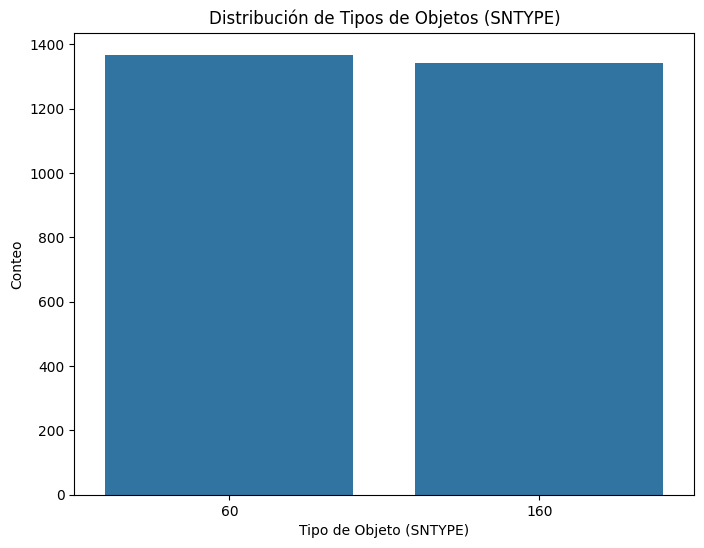

In [ ]:

# Conteo de tipos de objetos
plt.figure(figsize=(8, 6))
sns.countplot(x='SNTYPE', data=info)
plt.title('Distribución de Tipos de Objetos (SNTYPE)')
plt.xlabel('Tipo de Objeto (SNTYPE)')
plt.ylabel('Conteo')
plt.show()


Interpretación: La distribución entre los tipos 60 y 160 es bastante equilibrada, lo que indica que el dataset tiene una representación similar de ambos tipos de objetos. Esto es importante para cualquier análisis posterior, ya que permite comparaciones entre tipos sin sesgos significativos.

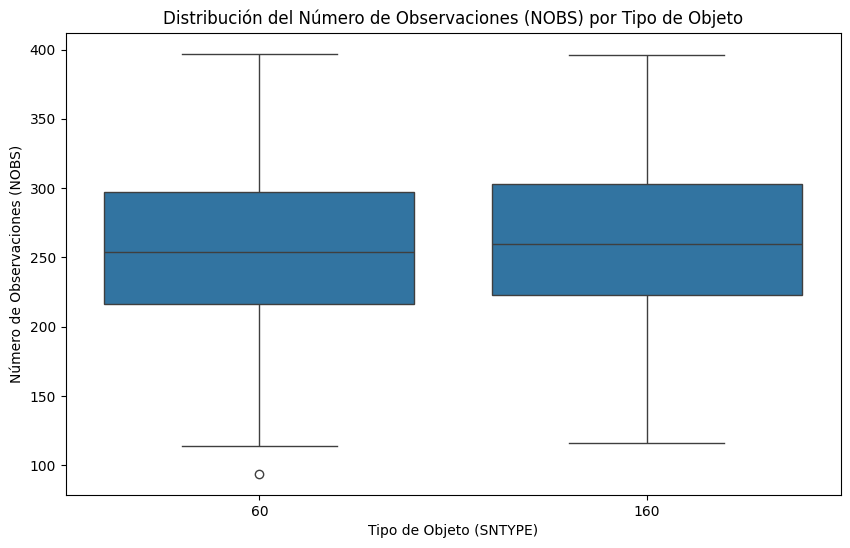

In [ ]:
# Boxplot para NOBS por tipo de objeto
plt.figure(figsize=(10, 6))
sns.boxplot(x='SNTYPE', y='NOBS', data=info)
plt.title('Distribución del Número de Observaciones (NOBS) por Tipo de Objeto')
plt.xlabel('Tipo de Objeto (SNTYPE)')
plt.ylabel('Número de Observaciones (NOBS)')
plt.show()

Interpretación: Ambas categorías de objetos tienen una distribución similar en términos de número de observaciones, con medianas alrededor de 250 observaciones. Sin embargo, el rango intercuartílico es amplio, lo que indica variabilidad en la cantidad de datos disponibles por objeto. También se observa un outlier en el tipo 60, que podría ser un objeto con significativamente menos observaciones que el resto.

#### Relación entre Número de Observaciones (NOBS) y Otras Variables

Objetivo: Explorar cómo el número de observaciones se relaciona con otras variables como RA, DEC, o tipos de objetos

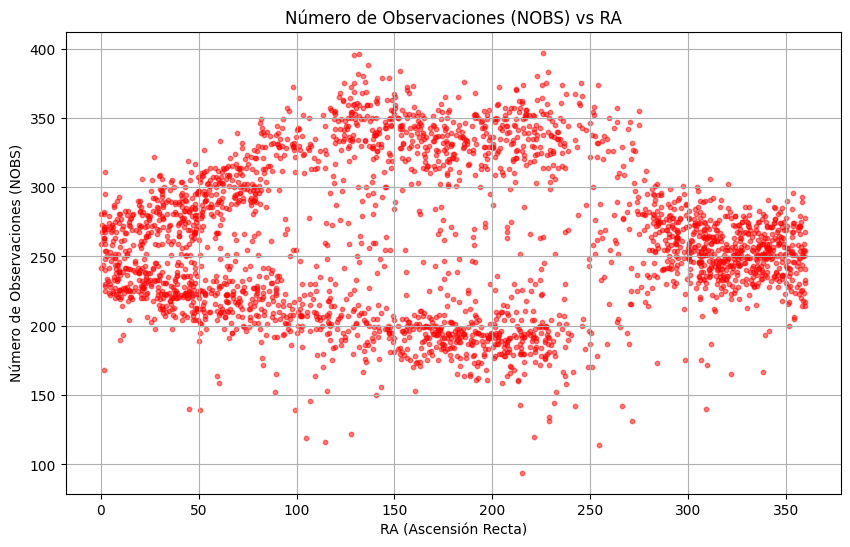

In [ ]:
# Scatter plot de NOBS versus RA y DEC
plt.figure(figsize=(10, 6))
plt.scatter(info['RA'], info['NOBS'], alpha=0.5, s=10, c='red')
plt.title('Número de Observaciones (NOBS) vs RA')
plt.xlabel('RA (Ascensión Recta)')
plt.ylabel('Número de Observaciones (NOBS)')
plt.grid(True)
plt.show()


Interpretación: Existe una cierta concentración de objetos con un número alto de observaciones en determinadas regiones de RA (e.g., alrededor de 300 grados). Esto podría indicar áreas de interés particular en el cielo donde se hicieron más observaciones, o una estrategia de observación específica.

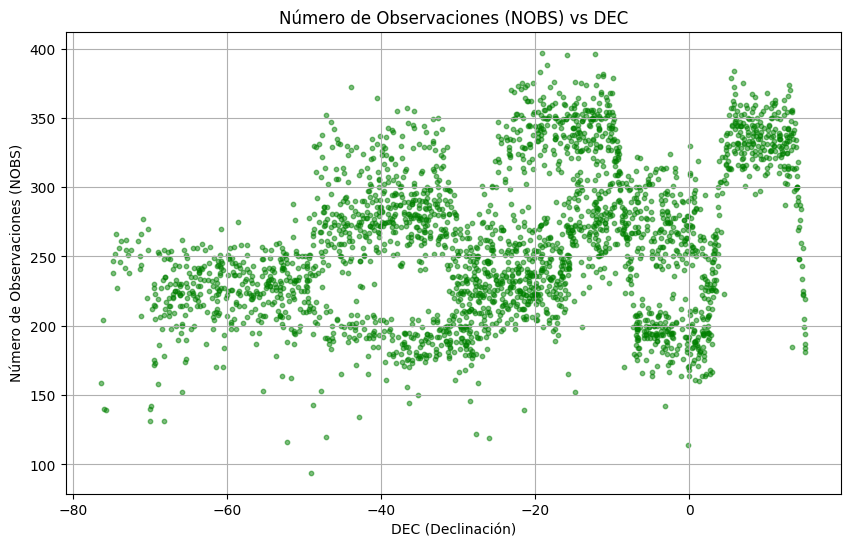

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(info['DEC'], info['NOBS'], alpha=0.5, s=10, c='green')
plt.title('Número de Observaciones (NOBS) vs DEC')
plt.xlabel('DEC (Declinación)')
plt.ylabel('Número de Observaciones (NOBS)')
plt.grid(True)
plt.show()

Interpretación: Al igual que con RA, existe una relación en la que ciertas regiones de DEC tienen más observaciones. Los datos parecen concentrarse en torno a ciertas declinaciones, lo que podría estar relacionado con la cobertura del telescopio.

Interpretación: Ambas categorías de objetos tienen una distribución similar en términos de número de observaciones, con medianas alrededor de 250 observaciones. Sin embargo, el rango intercuartílico es amplio, lo que indica variabilidad en la cantidad de datos disponibles por objeto. También se observa un outlier en el tipo 60, que podría ser un objeto con significativamente menos observaciones que el resto.

#### Análisis de Flujo y Error en el Flujo (FLUX y FLUXERR)

Objetivo: Analizar la distribución del flujo y su error para comprender la calidad de las observaciones (FLUX y FLUXERR).

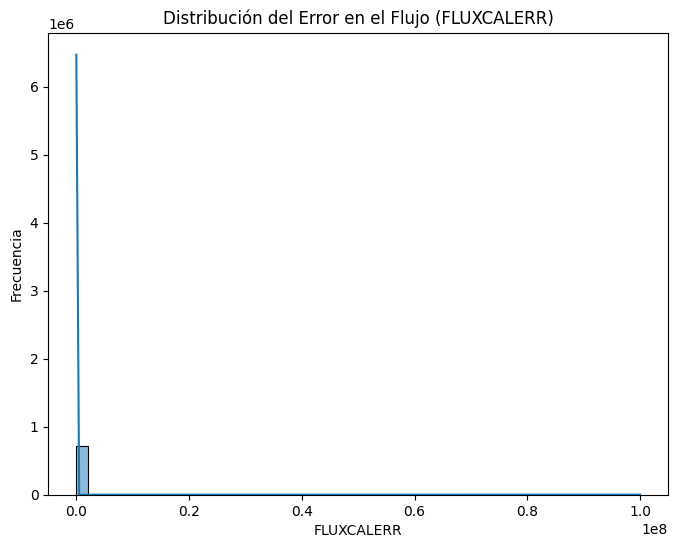

In [ ]:
# Histogramas para FLUX y FLUXERR (si están presentes)
if 'FLUX' in phot.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(phot['FLUXCAL'], bins=50, kde=True)
    plt.title('Distribución del Flujo (FLUXCAL)')
    plt.xlabel('FLUXCAL')
    plt.ylabel('Frecuencia')
    plt.show()

if 'FLUXCALERR' in phot.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(phot['FLUXCALERR'], bins=50, kde=True)
    plt.title('Distribución del Error en el Flujo (FLUXCALERR)')
    plt.xlabel('FLUXCALERR')
    plt.ylabel('Frecuencia')
    plt.show()


Interpretación: La gran mayoría de los errores están concentrados cerca de cero, pero hay un número muy pequeño de observaciones con errores extremadamente grandes. Esto podría sugerir la presencia de valores atípicos o problemas en ciertas observaciones que podrían necesitar un tratamiento especial (como eliminación o corrección).

In [ ]:
# Identificar outliers usando el método IQR (Interquartile Range)
Q1 = phot['FLUXCALERR'].quantile(0.25)
Q3 = phot['FLUXCALERR'].quantile(0.75)
IQR = Q3 - Q1

# Definir el rango de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = phot[(phot['FLUXCALERR'] < lower_bound) | (phot['FLUXCALERR'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 29019


El resultado muestra que hay 29,019 outliers en la columna FLUXCALERR de tu dataset phot, basados en el método del rango intercuartílico (IQR). Esto indica que un número significativo de observaciones tiene errores de flujo que son muy altos o muy bajos en comparación con la distribución general de los datos.

In [ ]:
print(outliers.head())

            MJD BAND  CCDNUM         FIELD  PHOTFLAG  PHOTPROB     FLUXCAL  \
0    60395.4122   Y       -9  VOID                 0      -9.0   26.097782   
67   60573.1592   Y       -9  VOID                 0      -9.0    8.029141   
75   60601.1273   Y       -9  VOID                 0      -9.0   -3.888515   
118  60829.4171   Y       -9  VOID                 0      -9.0  102.758011   
149  60870.4031   z       -9  VOID                 0      -9.0   64.154106   

     FLUXCALERR  PSF_SIG1  PSF_SIG2  ...    SKY_SIG  SKY_SIG_T  RDNOISE  \
0     48.676758      2.18       0.0  ...  70.879997        0.0     0.25   
67    49.126564      3.00       0.0  ...  47.419998        0.0     0.25   
75    43.545719      2.15       0.0  ...  52.500000        0.0     0.25   
118   57.412045      4.16       0.0  ...  41.810001        0.0     0.25   
149   66.863213      6.07       0.0  ...  72.470001        0.0     0.25   

        ZEROPT  ZEROPT_ERR  GAIN  XPIX  YPIX  SIM_FLUXCAL_HOSTERR  SIM_MAGOBS  


#### Correlación entre Variables

Objetivo: Identificar posibles relaciones lineales entre diferentes variables numéricas.

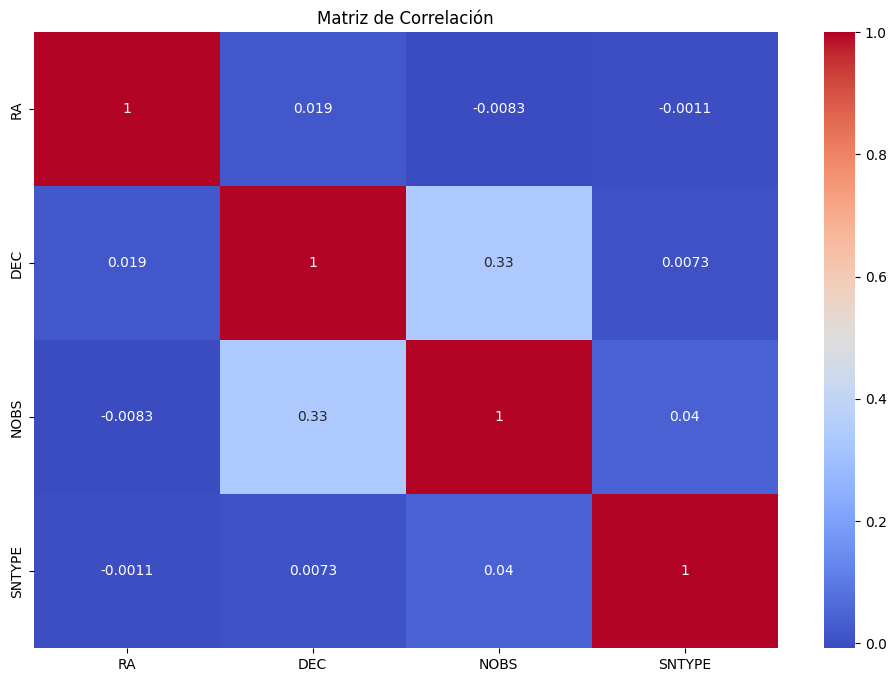

In [ ]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
correlation_matrix = info[['RA', 'DEC', 'NOBS', 'SNTYPE']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


Interpretación:

RA y DEC no están correlacionados, lo que es esperado ya que son coordenadas independientes en el cielo.

NOBS tiene una correlación moderada con DEC (0.33), lo que podría sugerir que la posición en el cielo afecta la cantidad de observaciones. Sin embargo, no hay correlaciones fuertes que sugieran relaciones lineales claras entre estas variables.

#### Distribución de MJD

Objetivo: Entender la distribución de los tiempos de observación.

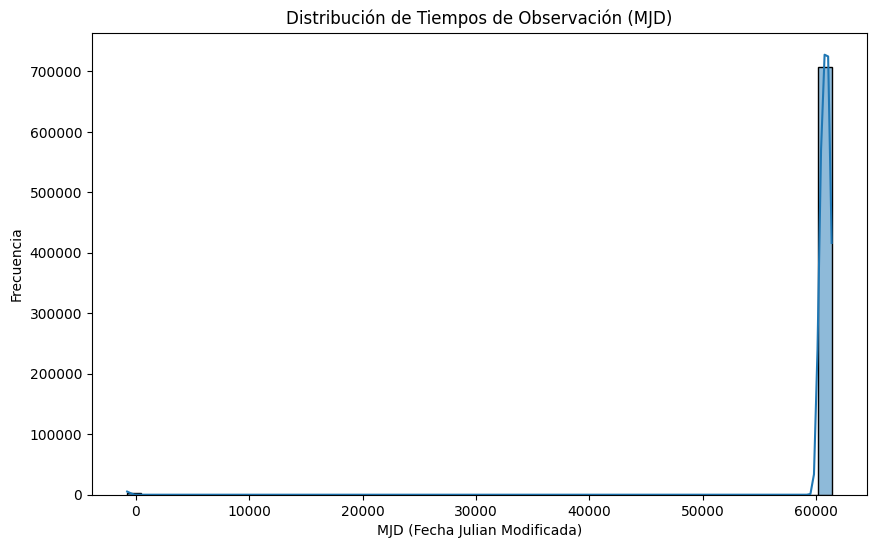

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(phot['MJD'], bins=50, kde=True)
plt.title('Distribución de Tiempos de Observación (MJD)')
plt.xlabel('MJD (Fecha Julian Modificada)')
plt.ylabel('Frecuencia')
plt.show()

Interpretación: La mayoría de las observaciones están concentradas en un rango muy estrecho de fechas alrededor de MJD ~ 60000. Esto sugiere que las observaciones se realizaron en un período de tiempo relativamente corto. Los valores extremadamente bajos de MJD, que aparecen en el gráfico, pueden ser errores en los datos o valores no válidos que deberían ser investigados y potencialmente eliminados.

Objetivo: Ver cómo el flujo (FLUXCAL) varía con el tiempo para identificar patrones o eventos astronómicos.

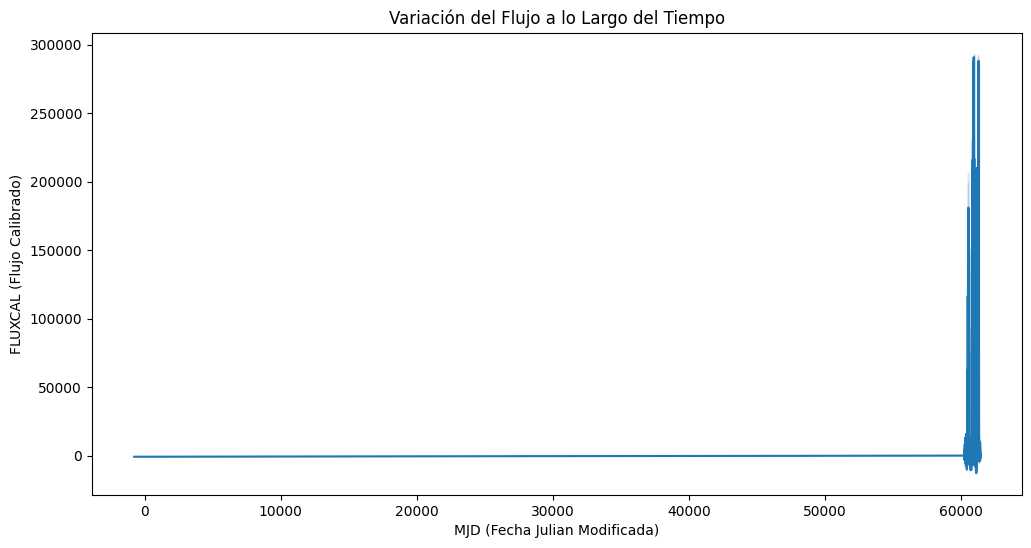

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='MJD', y='FLUXCAL', data=phot)
plt.title('Variación del Flujo a lo Largo del Tiempo')
plt.xlabel('MJD (Fecha Julian Modificada)')
plt.ylabel('FLUXCAL (Flujo Calibrado)')
plt.show()

Interpretación: La segunda gráfica muestra que el flujo (FLUXCAL) también está concentrado en el mismo período estrecho de tiempo, reflejando la alta densidad de observaciones en ese rango. Los valores muy altos de flujo, observados como picos, podrían ser indicativos de eventos astronómicos como supernovas. Sin embargo, la mayoría del flujo está cerca de cero, lo que sugiere que muchos objetos son débiles o que las observaciones no detectaron un flujo significativo en esos momentos.

#### Análisis de BAND (Filtro Fotométrico)

Objetivo: Ver la cantidad de observaciones realizadas en cada filtro fotométrico.

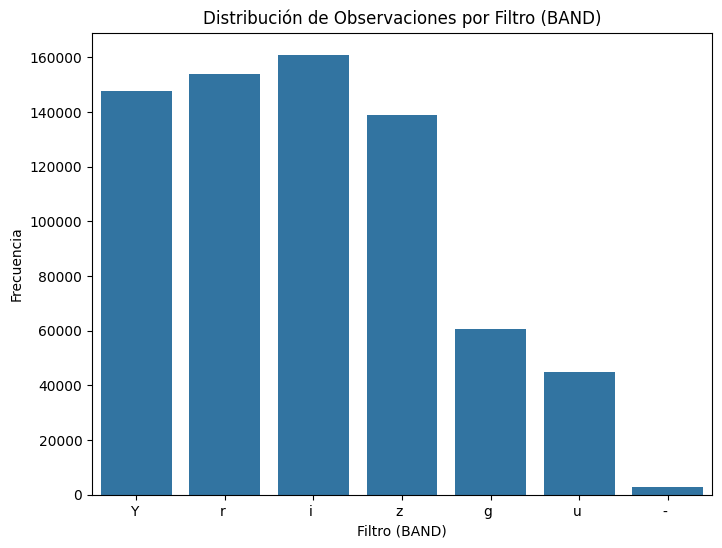

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='BAND', data=phot)
plt.title('Distribución de Observaciones por Filtro (BAND)')
plt.xlabel('Filtro (BAND)')
plt.ylabel('Frecuencia')
plt.show()

Interpretación: La tercera gráfica muestra que las observaciones no están distribuidas uniformemente entre los diferentes filtros fotométricos. Los filtros Y, r, i, y z tienen más observaciones que los filtros g y u. Esto podría deberse a que ciertos filtros son más efectivos o que las observaciones en esas bandas fueron más prioritarias.

Objetivo: Comparar cómo varía el flujo a través de diferentes filtros.

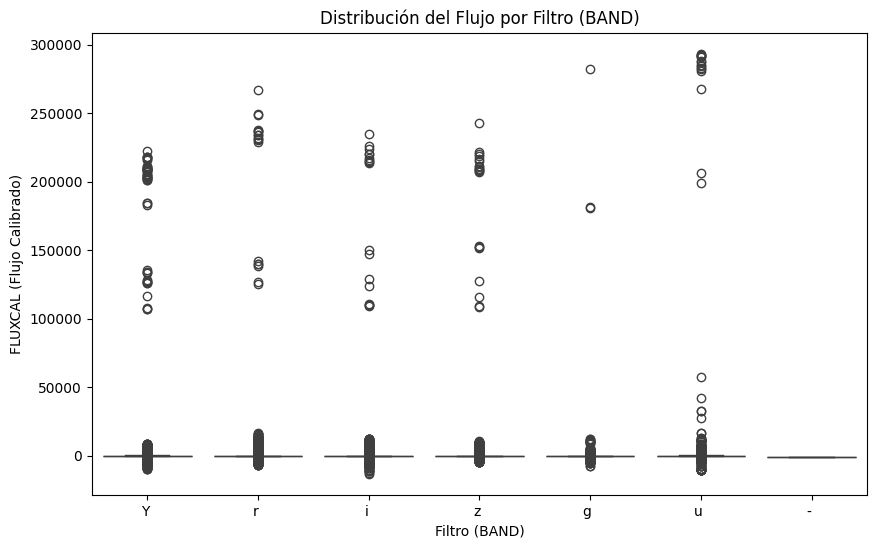

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAND', y='FLUXCAL', data=phot)
plt.title('Distribución del Flujo por Filtro (BAND)')
plt.xlabel('Filtro (BAND)')
plt.ylabel('FLUXCAL (Flujo Calibrado)')
plt.show()

Interpretación: La cuarta gráfica (boxplot) indica que el flujo varía considerablemente entre diferentes filtros. Los outliers en cada filtro representan observaciones con flujo muy alto, posiblemente eventos astronómicos significativos como supernovas o errores en la medición. La mayoría de los datos están concentrados en valores bajos de flujo, y hay variación en el rango de los valores típicos entre los filtros.

#### Análisis de FLUXCAL y FLUXCALERR

Objetivo: Distribución de FLUXCAL. Ver la distribución de los valores de flujo observados.

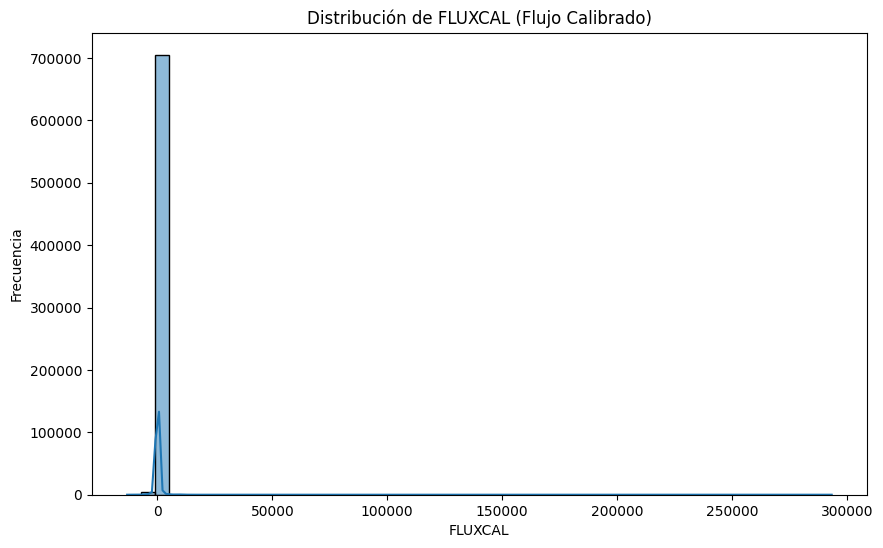

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(phot['FLUXCAL'], bins=50, kde=True)
plt.title('Distribución de FLUXCAL (Flujo Calibrado)')
plt.xlabel('FLUXCAL')
plt.ylabel('Frecuencia')
plt.show()

Interpretación: La quinta gráfica muestra que la gran mayoría de los valores de flujo están cerca de cero, lo que sugiere que muchos objetos no emiten mucho o que están muy lejos, haciendo difícil su detección. Los valores extremadamente altos pueden ser outliers que necesitan ser investigados, ya que podrían representar fenómenos astronómicos reales o errores en los datos.

Objetivo: Relación entre FLUXCAL y FLUXCALERR. Entender cómo el error en el flujo varía con el valor del flujo observado.

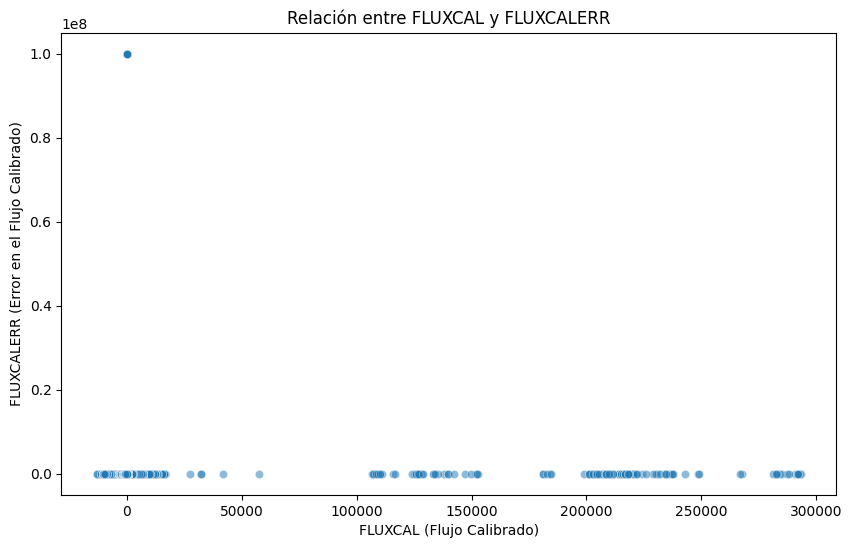

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FLUXCAL', y='FLUXCALERR', data=phot, alpha=0.5)
plt.title('Relación entre FLUXCAL y FLUXCALERR')
plt.xlabel('FLUXCAL (Flujo Calibrado)')
plt.ylabel('FLUXCALERR (Error en el Flujo Calibrado)')
plt.show()


Interpretación: La sexta gráfica sugiere que hay una gran cantidad de puntos con valores bajos de FLUXCALERR (error en el flujo) y flujos pequeños, lo cual es esperado. Sin embargo, hay algunos puntos con errores extremadamente altos que son anómalos. Estos puntos necesitan ser analizados con más detalle para determinar si deben ser considerados outliers y ser eliminados del análisis.

#### Análisis de PSF_SIG1 y PSF_SIG2

Objetivo: Distribución de PSF_SIG1. Ver la distribución de los valores de PSF_SIG1.

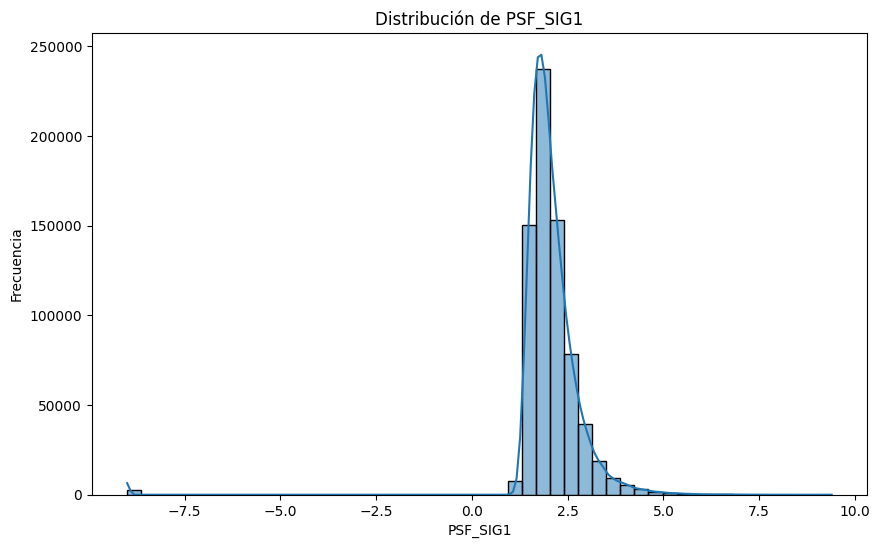

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(phot['PSF_SIG1'], bins=50, kde=True)
plt.title('Distribución de PSF_SIG1')
plt.xlabel('PSF_SIG1')
plt.ylabel('Frecuencia')
plt.show()

Interpretación: La séptima gráfica muestra una distribución unimodal de PSF_SIG1, que es una medida de la calidad de la imagen. La mayoría de los valores están en un rango relativamente estrecho alrededor de 2.0, lo que indica una calidad de imagen consistente. Los valores negativos o muy bajos pueden ser anómalos y deberían ser revisados.

Objetivo: Relación entre PSF_SIG1, PSF_SIG2 y FLUXCALERR. Entender cómo la dispersión del punto afecta la precisión de las mediciones de flujo.

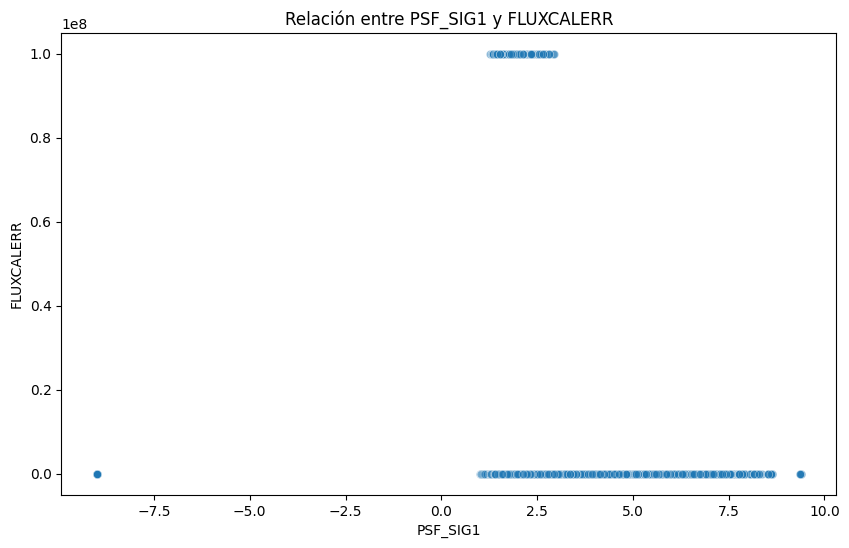

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PSF_SIG1', y='FLUXCALERR', data=phot, alpha=0.5)
plt.title('Relación entre PSF_SIG1 y FLUXCALERR')
plt.xlabel('PSF_SIG1')
plt.ylabel('FLUXCALERR')
plt.show()

Interpretación: La octava gráfica muestra que la mayoría de las observaciones con un PSF_SIG1 normal (cerca de 2.0) tienen errores de flujo relativamente pequeños. Los puntos en los extremos (con PSF_SIG1 negativo o muy alto) están asociados con errores de flujo altos o anómalos, lo que sugiere que la calidad de la imagen afecta la precisión del flujo medido.

#### Comparación entre SIM_MAGOBS y FLUXCAL

Objetivo: Conversión de FLUXCAL a Magnitud y Comparación con SIM_MAGOBS. Convertir el flujo a magnitudes y compararlo con las magnitudes observadas simuladas para validar la precisión de las simulaciones.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


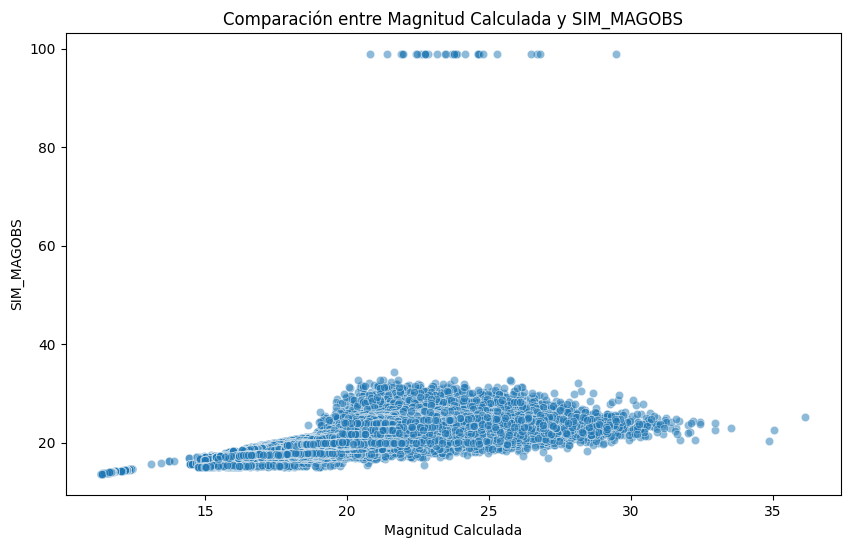

In [ ]:

# Convertir FLUXCAL a magnitud
phot['MAG_CALCULATED'] = -2.5 * np.log10(phot['FLUXCAL']) + 25  # El 25 es un valor de normalización común

# Scatter plot de comparación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MAG_CALCULATED', y='SIM_MAGOBS', data=phot, alpha=0.5)
plt.title('Comparación entre Magnitud Calculada y SIM_MAGOBS')
plt.xlabel('Magnitud Calculada')
plt.ylabel('SIM_MAGOBS')
plt.show()


Interpretación: La novena gráfica muestra una dispersión entre la magnitud calculada a partir del flujo y la magnitud simulada (SIM_MAGOBS). Los datos se agrupan principalmente en magnitudes calculadas entre 15 y 25, mientras que hay un grupo de outliers con magnitudes observadas simuladas significativamente mayores (cerca de 100), lo que sugiere errores en los datos o en la simulación.

# **3. Limpieza y preparación de datos**


In [ ]:
print(info.columns)

Index(['SNID', 'IAUC', 'FAKE', 'RA', 'DEC', 'PIXSIZE', 'NXPIX', 'NYPIX',
       'SNTYPE', 'NOBS',
       ...
       'SIM_EXPOSURE_i', 'SIM_EXPOSURE_z', 'SIM_EXPOSURE_Y', 'SIM_GALFRAC_u',
       'SIM_GALFRAC_g', 'SIM_GALFRAC_r', 'SIM_GALFRAC_i', 'SIM_GALFRAC_z',
       'SIM_GALFRAC_Y', 'SIM_SUBSAMPLE_INDEX'],
      dtype='object', length=180)


In [ ]:
info.head()

,SNID,IAUC,FAKE,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,...,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y,SIM_SUBSAMPLE_INDEX
0,51107972,NULL,2,296.259102,-34.313543,0.2,-9,-9,160,285,...,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9
1,25298190,NULL,2,52.736585,-9.192910,0.2,-9,-9,160,311,...,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9
2,59881870,NULL,2,330.664480,-46.783714,0.2,-9,-9,60,267,...,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9
3,8799114,NULL,2,61.031793,-33.249961,0.2,-9,-9,160,333,...,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9
4,59381779,NULL,2,40.416355,-12.668474,0.2,-9,-9,160,280,...,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9


In [ ]:
info_clean = info.drop(['SIM_GALFRAC_u',
       'SIM_GALFRAC_g', 'SIM_GALFRAC_r', 'SIM_GALFRAC_i', 'SIM_GALFRAC_z',
       'SIM_GALFRAC_Y', 'PIXSIZE', 'NXPIX', 'NYPIX', 'SIM_EXPOSURE_i',
       'SIM_EXPOSURE_z', 'SIM_EXPOSURE_Y', 'FAKE'], axis=1)

In [ ]:
info_clean.columns

Index(['SNID', 'IAUC', 'RA', 'DEC', 'SNTYPE', 'NOBS', 'PTROBS_MIN',
       'PTROBS_MAX', 'MWEBV', 'MWEBV_ERR',
       ...
       'SIM_TEMPLATEMAG_u', 'SIM_TEMPLATEMAG_g', 'SIM_TEMPLATEMAG_r',
       'SIM_TEMPLATEMAG_i', 'SIM_TEMPLATEMAG_z', 'SIM_TEMPLATEMAG_Y',
       'SIM_EXPOSURE_u', 'SIM_EXPOSURE_g', 'SIM_EXPOSURE_r',
       'SIM_SUBSAMPLE_INDEX'],
      dtype='object', length=167)

In [ ]:
phot.head()

,MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,...,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX,SIM_FLUXCAL_HOSTERR,SIM_MAGOBS,MAG_CALCULATED
0,60395.4122,Y,-9,VOID,0,-9.0,26.097782,48.676758,2.18,0.0,...,0.0,0.25,30.129999,0.005,1.0,-9.0,-9.0,0.0,22.240976,21.458490
1,60418.3483,r,-9,VOID,0,-9.0,12.046535,5.664841,2.35,0.0,...,0.0,0.25,31.530001,0.005,1.0,-9.0,-9.0,0.0,22.569517,22.297844
2,60418.3488,r,-9,VOID,0,-9.0,25.969179,5.614565,2.35,0.0,...,0.0,0.25,31.530001,0.005,1.0,-9.0,-9.0,0.0,22.569059,21.463854
3,60418.3727,i,-9,VOID,0,-9.0,-17.301144,6.606749,1.86,0.0,...,0.0,0.25,31.330000,0.005,1.0,-9.0,-9.0,0.0,22.551102,NaN
4,60418.3731,i,-9,VOID,0,-9.0,-10.961698,6.595722,1.87,0.0,...,0.0,0.25,31.330000,0.005,1.0,-9.0,-9.0,0.0,22.550978,NaN


In [ ]:
X = data.drop([''],axis=1)
Y = data['']

Así mismo, dado que nuestro algoritmo solo entiende números, se va a transformar nuestra variable categórica a una columna de números.

In [ ]:
le = LabelEncoder()

le.fit(Y)

Y = le.transform(Y)
print(le.classes_)
Y

#### **Transformación de Datos**

Debido a que la transformación de datos puede significar la construcción de varios pasos, como el manejo de faltantes, la normalización de datos, la transformación de variables categóricas, entre otros. Se pone en práctica el uso de [Pipeline](https://scikit-learn.org/stable/modules/compose.html), el cual es una herramienta de Sklearn que nos permite unir todos estos procesos y realizar de forma automática todas las transformaciones que necesitemos.

In [ ]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
              ('encoder', OrdinalEncoder()),
              ]
pipe = Pipeline(estimators)
pipe

In [ ]:
X_mod = pipe.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

In [ ]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
              ('encoder', OrdinalEncoder()),
              ('normalize',MinMaxScaler()),
              ]
pipe2 = Pipeline(estimators)
pipe2

In [ ]:
X_mod = pipe2.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

# **4. Modelamiento**

Los Pipelines no solo sirven para construir los datos, transformarlos y adaptarlos. También sirven para conectar un modelo de aprendizaje, ya sea para predecir, clasificar o estimar.

In [ ]:
estimators = [('preprocessing', pipe),
              ('clf',LogisticRegression(solver='liblinear')),
              ]
model = Pipeline(estimators)
model

In [ ]:
model.fit(X,Y)

Construimos un segundo Pipeline para poder comparar rendimientos.

In [ ]:
estimators = [('preprocessing', pipe2),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
model2 = Pipeline(estimators)
model2

In [ ]:
model2.fit(X,Y)

# **5. Predicción**

#### **Predicción del clasificador**

Al igual que en la transformación de Datos, el conjunto de entrada de nuestro modelo serán los datos originales. Pero ahora al incluir un clasificador, el retornará la clase a la cual está prediciendo el dato.

In [ ]:
pred1 = model.predict(X)
display(pred1)
pred2 = model2.predict(X)
display(pred2)

Al obtener un modelo de clasificación y dado nuestras predicciones, podemos construir una matriz de confusión para nuestros modelos.

La documentación de la función la encuentran en la [página de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

In [ ]:
conf_matrix = confusion_matrix(Y, pred1)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues', values_format='d')
# Añade etiquetas y muestra el gráfico
plt.title('Matriz de Confusión')
plt.show()


conf_matrix2 = confusion_matrix(Y, pred2)
disp = ConfusionMatrixDisplay(conf_matrix2)
disp.plot(cmap='Blues', values_format='d')
# Añade etiquetas y muestra el gráfico
plt.title('Matriz de Confusión 2')
plt.show()

Y por último, para comparar nuestros modelos, utilizaremos un reporte el cual nos muestra la precisión, la cobertura, y la métrica f1 de las predicciones de ambos modelos.

In [ ]:
print('----------Reporte para el Modelo 1----------')
print(classification_report(Y,pred1,target_names=le.classes_))
print('----------Reporte para el Modelo 2----------')
print(classification_report(Y,pred2,target_names=le.classes_))

#### **Selección de Hiperparámetros**

Otra gran ventaja de los Pipeline, es que nos permite seleccionar los hiperparámetros de construcción para obtener nuestro mejor modelo. Esta construcción la realiza a través de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Y nos permite escoger los hiperparámetros de cada una de nuestras etapas del Pipeline. También podemos escoger si decidimos utilizar un paso o no.

In [ ]:
ct = ColumnTransformer([
       ('num', SimpleImputer(strategy='mean'),
       make_column_selector(dtype_include=np.number)),
       ('cat',
       SimpleImputer(strategy='most_frequent'),
       make_column_selector(dtype_include=object))])

estimators = [('imputer', ct),
              ('encoder', OrdinalEncoder()),
              ('normalize',MaxAbsScaler()),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
pipe = Pipeline(estimators)

param_grid = dict(imputer__num__strategy=['mean', 'median'],
                  imputer__cat__strategy=['most_frequent', 'constant'],
                  encoder=[OrdinalEncoder(), OneHotEncoder()],
                  normalize=['passthrough', MaxAbsScaler()])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3,scoring='accuracy')

grid_search.fit(X,Y.ravel())

Ya que nuestro GridSearch entrenó todos los modelos, ahora podemos visualizar cuales fueron nuestros mejores hiperparámetros seleccionados, nuestro mejor modelo y una tabla de resultados de todos los modelos evaluados.

In [ ]:
print(grid_search.best_params_)

In [ ]:
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados)

Y por último, guardaremos nuestro modelo para utilizarlo después.

In [ ]:
dump(grid_search.best_estimator_, 'my_model.joblib')

model = load('my_model.joblib')

pred1 = model.predict(X)
print('----------Reporte para el Mejor Modelo----------')
print(classification_report(Y,pred1,target_names=le.classes_))

### **6. Validación**

